In [562]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ot
import random
import re
import seaborn as sns; sns.set()

from collections import Counter

def get_sinkhorn_objects(x, y, C, lam=1):
    """ Compute the Sinkhorn distance and transport matrix of distributions x and y  with respect to cost matrix C.
        lambda is the regularization parameter; high lambda => close to Wasserstein distance.
        Return a dict of the distance and matrix. """
    dist = ot.sinkhorn2(x, y, C, lam)
    mat = ot.sinkhorn(x, y, C, lam)
    hadamard = np.multiply(C, mat)

    return dict([("distance", dist), ("matrix", mat), ("Hadamard", hadamard)])

def get_empirical_distribution(df, n=10):
    """ Compute the frequency distribution of each TCR based on its clone_size count.
        n is the root for which each frequency is taken and scaled accordingly. 
        Return a vector of empirical probabilities. """
    clone_sizes = df['clone_size']
    return clone_sizes**(1/n)/np.sum(clone_sizes**(1/n))


In [563]:
# Read in and preprocess the data
clone_df = pd.read_csv("Data/tmp_mouse_clones.tsv", sep="\t")
clone_df['clone_freq'] = clone_df['clone_size']/np.sum(clone_df['clone_size'])
# Only keep last two digits of subject id (there are 78 ids total)
clone_df['subject'] = [int(subject[-2:]) for subject in clone_df['subject']]
dist_df = pd.read_csv("Data/tmp_mouse_clones_AB.dist", sep=" ", header=None)
dist_df = dist_df.drop(dist_df.columns[0], axis=1)

In [564]:
subjects = np.unique(clone_df['subject'])
epitopes = np.unique(clone_df['epitope'])

# Hash each subject to their epitope
subject_epitopes = dict((subject, epitope) for (subject, epitope) in zip(clone_df['subject'], clone_df['epitope']))

epitope_2mers = []
for e1 in epitopes:
    for e2 in epitopes:
        epitope_2mers.append(e1 + e2)

# Enumerate each (epitope_i, epitope_j) pair, mainly for plotting purposes 
epitope_2mer_factors = pd.factorize(epitope_2mers)
epitope_factor_dict = dict((epitope_2mer, factor) for (epitope_2mer, factor) in zip(epitope_2mer_factors[1], epitope_2mer_factors[0]))

In [565]:
# Make a dictionary of epitope-specific data frames
epitope_dfs = dict((epitope, clone_df[clone_df['epitope'] == epitope]) for epitope in epitopes)

# Get empirical distributions for each epitope-specific dataset
epitope_freqs = dict((epitope, get_empirical_distribution(epitope_dfs[epitope])) for epitope in epitopes)

# Get Sinkhorn(1) distance of each (epitope_i, epitope_j) pair
ep_dist_df = pd.DataFrame(columns=epitopes)
distance_matrices = []
transport_matrices = []
product_matrices = []
for e1 in epitopes:
    ep_dist_df[e1] = 0
    for e2 in epitopes:
        sub_dist_df = dist_df.iloc[clone_df.index[clone_df['epitope'] == e1], clone_df.index[clone_df['epitope'] == e2]]
        distance_matrices.append(sub_dist_df.as_matrix())
        e1_e2_sinkhorn = get_sinkhorn_objects(epitope_freqs[e1], epitope_freqs[e2], sub_dist_df)
        transport_matrices.append(e1_e2_sinkhorn['matrix'])
        product_matrices.append(np.multiply(sub_dist_df.as_matrix(), e1_e2_sinkhorn['matrix']))
        ep_dist_df.loc[e1, e2] = e1_e2_sinkhorn['distance']
        ep_dist_df.loc[e2, e1] = ep_dist_df.loc[e1, e2]
    

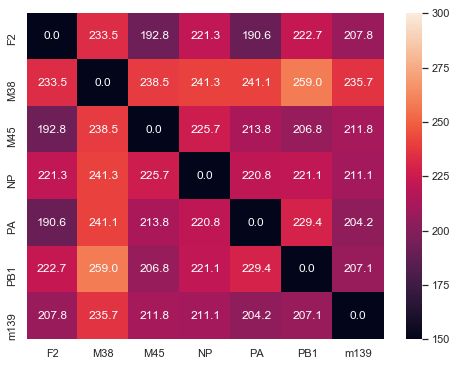

In [566]:
# Heatmap of Sinkhorn distances for each (epitope_i, epitope_j) pair

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(ep_dist_df, vmin=150, vmax=300, annot=True, fmt=".1f")

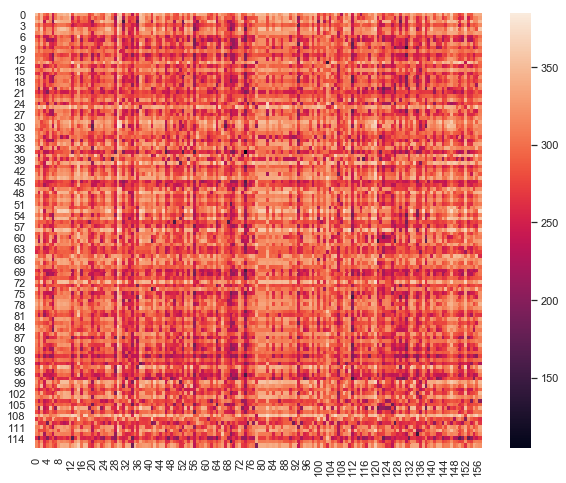

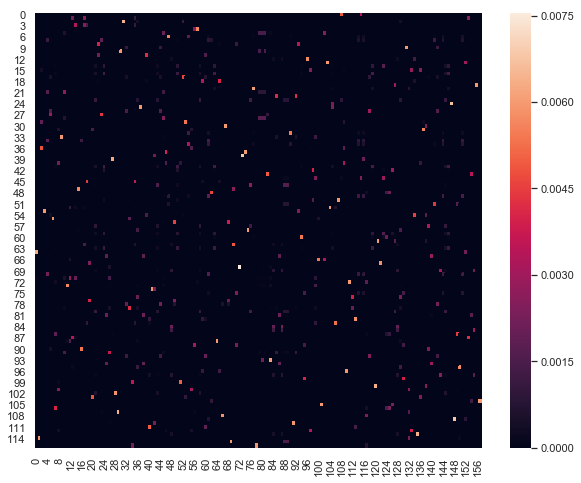

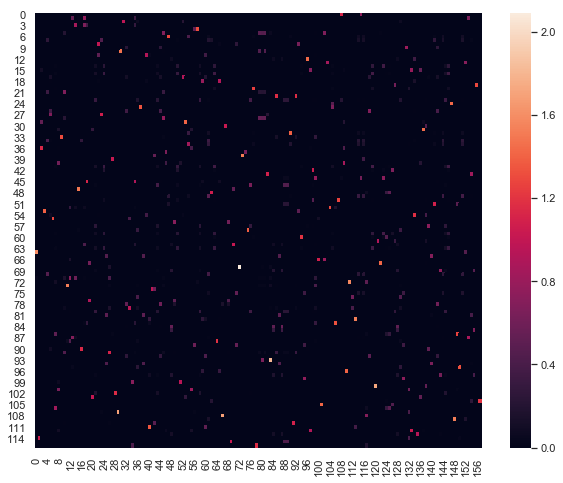

In [567]:
# Visualize an example distance matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(distance_matrices[1])

# Visualize an example transport matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(transport_matrices[1])

# Visualize an example Hadamard product of distance and transport matrices
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(product_matrices[1])

In [568]:
# Make a dictionary of subject-specific data frames
subject_dfs = dict((subject, clone_df[clone_df['subject'] == subject]) for subject in subjects)

# Get empirical distributions for each subject-specific dataset
subject_freqs = dict((subject, get_empirical_distribution(subject_dfs[subject])) for subject in subjects)

# Get Sinkhorn(1) distance of each (subject_i, subject_j) pair
subject_dist_df = pd.DataFrame(columns=subjects)
epitope_labels = pd.DataFrame(columns=subjects)
for s1 in subjects:
    subject_dist_df[s1] = 0
    epitope_labels[s1] = ''
    for s2 in subjects:
        # Compute sinkhorn distance of s1 and s2, and add to data frame
        sub_dist_df = dist_df.iloc[clone_df.index[clone_df['subject'] == s1], clone_df.index[clone_df['subject'] == s2]]
        subject_dist_df.loc[s1, s2] = get_sinkhorn_objects(subject_freqs[s1], subject_freqs[s2], sub_dist_df)['distance']
        subject_dist_df.loc[s2, s1] = subject_dist_df.loc[s1, s2]
        
        # Add unique label for epitopes of s1, s2 and add to data frame
        epitope_labels.loc[s1, s2] = epitope_factor_dict[subject_epitopes[s1] + subject_epitopes[s2]]
        epitope_labels.loc[s2, s1] = epitope_labels.loc[s1, s2]
        

/usr/local/lib/python3.6/site-packages/ot/bregman.py:387: RuntimeWarning: overflow encountered in square
  np.sum((v - vprev)**2) / np.sum((v)**2)
/usr/local/lib/python3.6/site-packages/ot/bregman.py:387: RuntimeWarning: invalid value encountered in double_scalars
  np.sum((v - vprev)**2) / np.sum((v)**2)


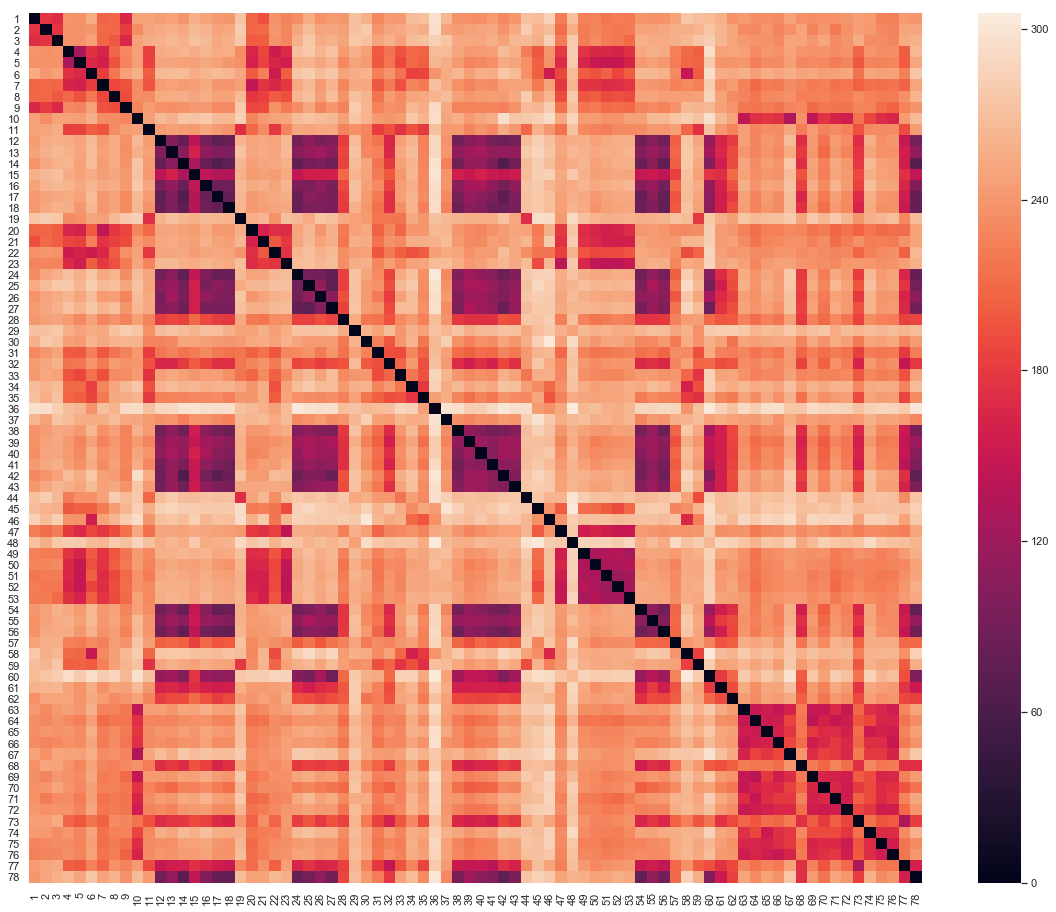

In [569]:
# Heatmap of Sinkhorn distances for each (subject_i, subject_j) pair
fig, ax = plt.subplots(figsize=(20,16))
hm = sns.heatmap(subject_dist_df, fmt=".1f", ax=ax)
plt.yticks(rotation=0)
plt.savefig('subject_heatmap.png')

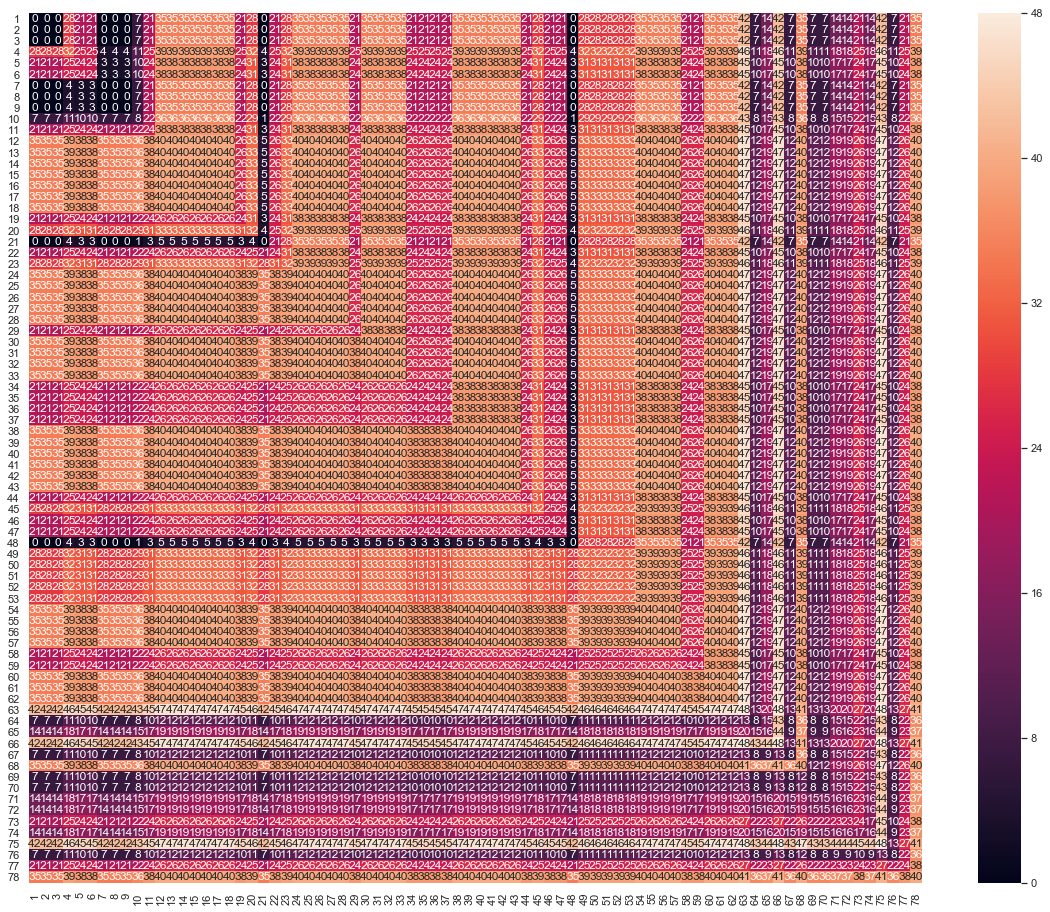

In [570]:
# Heatmap of enumerated labels for each (epitope_1, epitope_2) pair.
# E.g. ("F2", "F2"), ("M38", "NP"), ...
fig, ax = plt.subplots(figsize=(20, 16))

epitope_labels = epitope_labels[epitope_labels.columns].astype(int)
sns.heatmap(epitope_labels, fmt="d",annot=True)
plt.savefig('epitope_pairs_heatmap.png')

In [571]:
# Get Sinkhorn(1) distance of each ((subject_i, epitope_k), (subject_j, epitope_k)) pair
subjects_per_epitope = dict()
for e in epitopes:
    e_list = []
    e_subjects = np.unique(clone_df.loc[clone_df['epitope'] == e, ]['subject'])
    for s1 in e_subjects:
        for s2 in e_subjects:
            if s1 != s2:
                sub_dist_df = dist_df.iloc[clone_df.index[(clone_df['subject'] == s1) & (clone_df['epitope'] == e)] , clone_df.index[(clone_df['subject'] == s2) & (clone_df['epitope'] == e)]]
                freqs_1 = get_empirical_distribution(clone_df[(clone_df['subject'] == s1) & (clone_df['epitope'] == e)])
                freqs_2 = get_empirical_distribution(clone_df[(clone_df['subject'] == s2) & (clone_df['epitope'] == e)])
                e_list.extend(get_sinkhorn_objects(freqs_1, freqs_2, sub_dist_df)['distance'])
    subjects_per_epitope[e] = e_list
                

/usr/local/lib/python3.6/site-packages/ot/bregman.py:387: RuntimeWarning: overflow encountered in square
  np.sum((v - vprev)**2) / np.sum((v)**2)
/usr/local/lib/python3.6/site-packages/ot/bregman.py:387: RuntimeWarning: invalid value encountered in double_scalars
  np.sum((v - vprev)**2) / np.sum((v)**2)


([<matplotlib.axis.XTick at 0x126bd8ac8>,
 <a list of 7 Text xticklabel objects>)

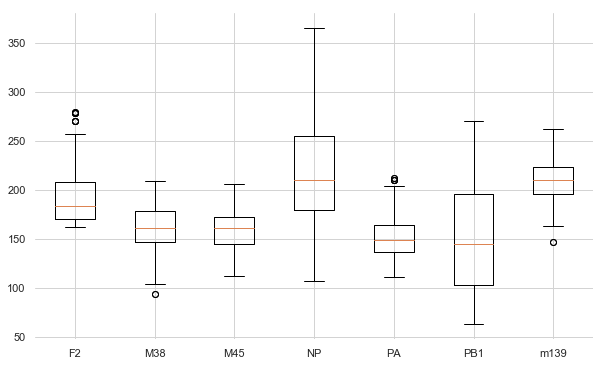

In [572]:
# Boxplot of per-subject variation of Sinkhorn distance within each epitope.
# Note that each subject is compared to each other subject, so that the distances in each group are correlated.
d = dict((epitope, subjects_per_epitope[epitope]) for epitope in epitopes)
labels, data = d.keys(), d.values()

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('white')
plt.grid(b=True, which='major', color='lightgrey', linestyle='-', zorder=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.boxplot(data, zorder=3)
plt.xticks(range(1, len(labels) + 1), labels)

In [573]:
Counter(clone_df['epitope'])
#PB1 has the most entries in the data, so let's examine V gene variation within PB1.

Counter(clone_df['subject'])
#Subject 72 has the most entries as well, though conditioning on an (epitope, subject) pair doesn't yield that interesting of a distribution 

pb1_df = clone_df[clone_df['epitope'] == 'PB1']


In [574]:
def get_epitope_items(full_df, epitope, gene):
    """ For a given epitope, return the epitope-specific dataset, empirical distribution, and list of unique genes """
    epitope_df = full_df[full_df['epitope'] == epitope]
    epitope_df.index = pd.RangeIndex(len(epitope_df))
    epitope_freqs = get_empirical_distribution(epitope_df)
    epitope_genes = sorted(np.unique(epitope_df[gene]))
    return epitope_df, epitope_freqs, epitope_genes
    
def run_gene_analysis(full_df, epitopes, gene):
    """ For a given pair of epitopes, compute a set of gene-specific matrices, including:
        'transport_averages': the average transport mass between each gene pair
        'transport_maxes': the maximum transport mass between each gene pair
        'transport_counts': the total number of times nonzero mass was transferred between each gene pair
        'hadamard_averages': the average hadamard entry for each gene pair
    """
    epitope1_df, epitope1_freqs, epitope1_genes = get_epitope_items(full_df=clone_df, epitope=epitopes[0], gene=gene)
    epitope2_df, epitope2_freqs, epitope2_genes = get_epitope_items(full_df=clone_df, epitope=epitopes[1], gene=gene)

    sub_dist_df = dist_df.iloc[clone_df.index[clone_df['epitope'] == epitopes[0]], \
                               clone_df.index[clone_df['epitope'] == epitopes[1]]]

    sinkhorn_objs = get_sinkhorn_objects(epitope1_freqs, epitope2_freqs, sub_dist_df)
    P = sinkhorn_objs['matrix']
    H = sinkhorn_objs['Hadamard'].as_matrix()

    gene_transport_averages = pd.DataFrame(columns=epitope2_genes, dtype="float")
    gene_transport_maxes = pd.DataFrame(columns=epitope2_genes, dtype="float")
    gene_transport_counts = pd.DataFrame(columns=epitope2_genes, dtype="float")
    gene_hadamard_averages = pd.DataFrame(columns=epitope2_genes, dtype="float")

    for gene1 in epitope1_genes:
        gene1_indices = epitope1_df.index[epitope1_df[gene] == gene1].values
        for gene2 in epitope2_genes:
            gene2_indices = epitope2_df.index[epitope2_df[gene] == gene2].values
            P_counts = 0
            P_subs = []
            H_subs = []
            for i in gene1_indices:
                for j in gene2_indices:
                    # Append a transport mass each time we see a row index i corresponding to gene1,
                    # and column index j corresponding to gene2.
                    P_subs.append(P[i, j])
                    H_subs.append(H[i, j])

                    P_counts += 1
            gene_transport_averages.loc[gene1, gene2] = np.mean(P_subs)
            gene_transport_maxes.loc[gene1, gene2] = np.max(P_subs)
            gene_transport_counts.loc[gene1, gene2] = P_counts
            gene_hadamard_averages.loc[gene1, gene2] = np.mean(H_subs)
    return dict([('transport_averages', gene_transport_averages), \
                 ('transport_maxes', gene_transport_maxes), \
                 ('transport_counts', gene_transport_counts), \
                 ('hadamard_averages', gene_hadamard_averages)])

def plot_gene_analysis_results(gene_items):
    """ Create a heatmap of each matrix result from run_gene_analysis """
    
    def plot_matrix(mat, width=10, height=6):
        fig, ax = plt.subplots(figsize=(width, height))
        sns.heatmap(mat)
    
    # Look at average Hadamard (work) value for each (gene_i, gene_j) pair
    plot_matrix(gene_items['hadamard_averages'])
    # Look at average transport mass for each (gene_i, gene_j) pair
    plot_matrix(gene_items['transport_averages'])
    # Look at maximum transport mass for each (gene_i, gene_j) pair
    plot_matrix(gene_items['transport_maxes'])
    # Look at how frequently a given (gene_i, gene_j) pair was observed
    plot_matrix(gene_items['transport_counts'])

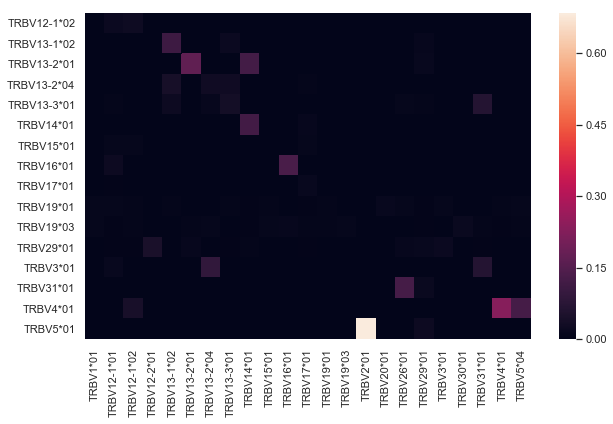

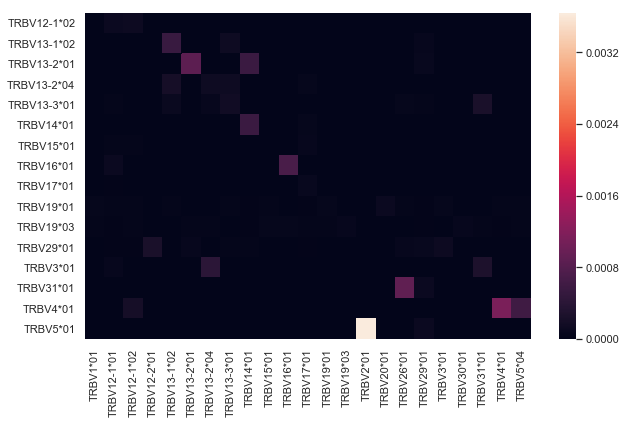

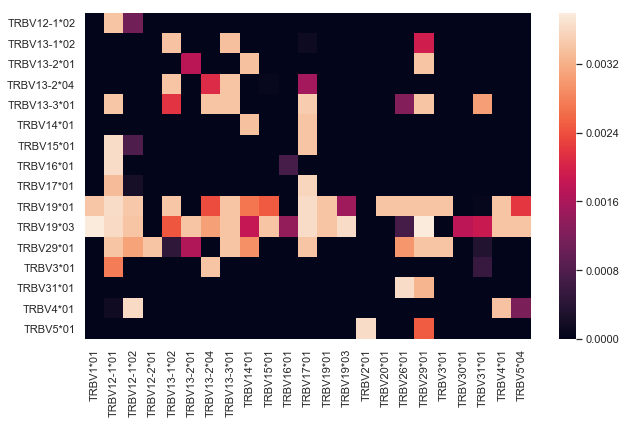

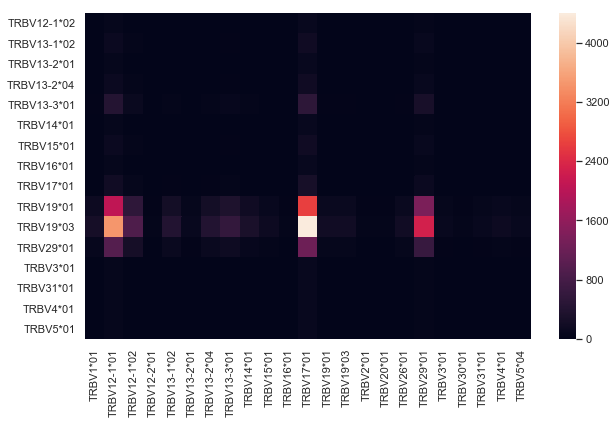

In [575]:
# F2 and M45 appear to be the most divergent epitopes. Let's investigate...
vb_gene_items = run_gene_analysis(full_df=clone_df, epitopes=('F2', 'M45'), gene='vb_gene')
plot_gene_analysis_results(vb_gene_items)

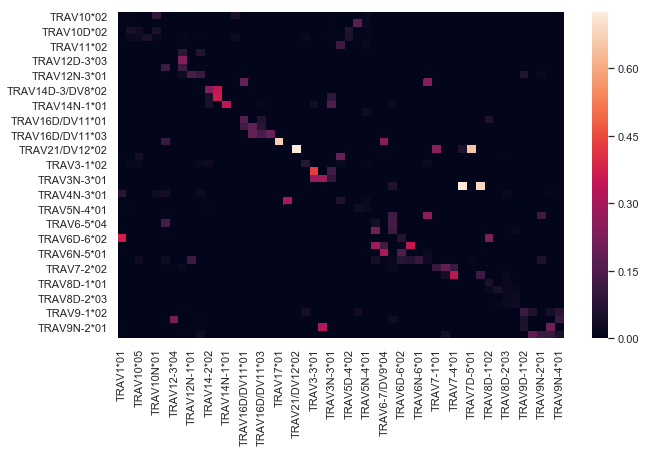

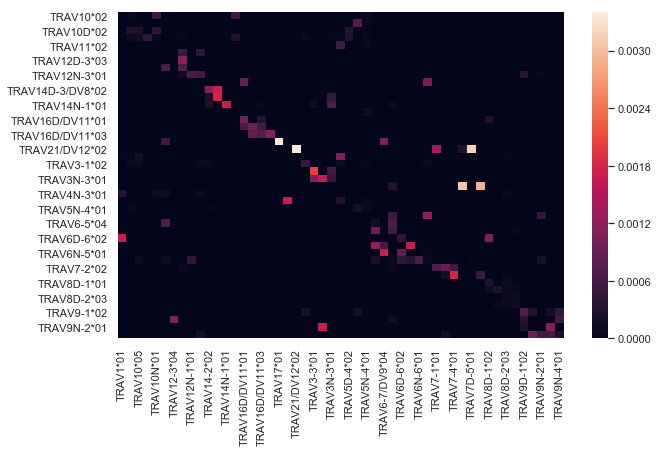

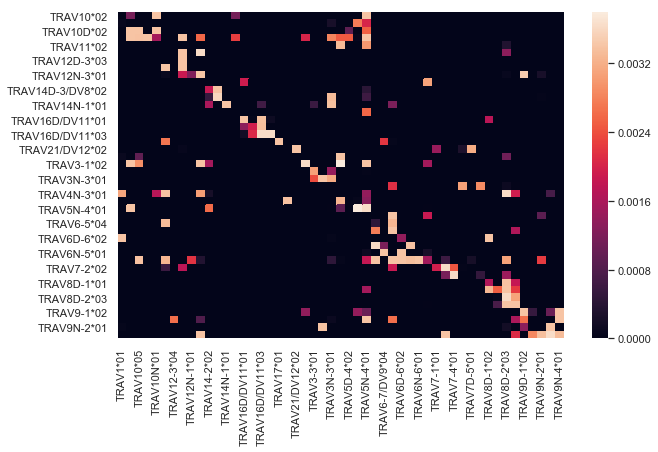

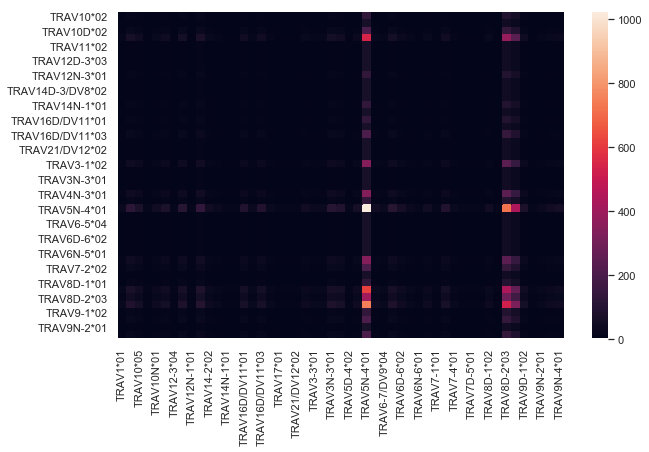

In [576]:
va_gene_items = run_gene_analysis(full_df=clone_df, epitopes=('F2', 'M45'), gene='va_gene')
plot_gene_analysis_results(va_gene_items)

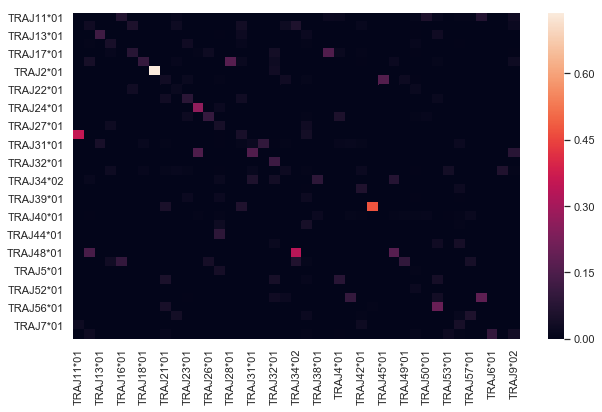

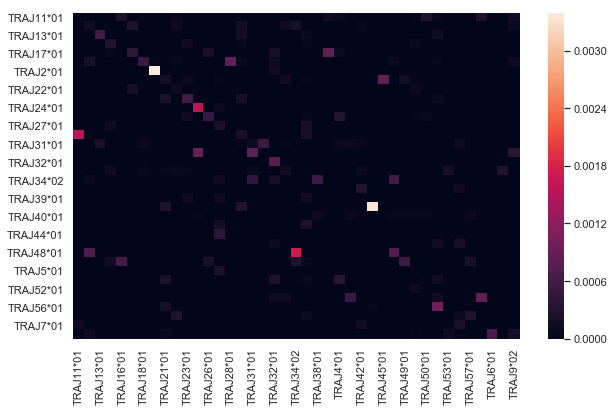

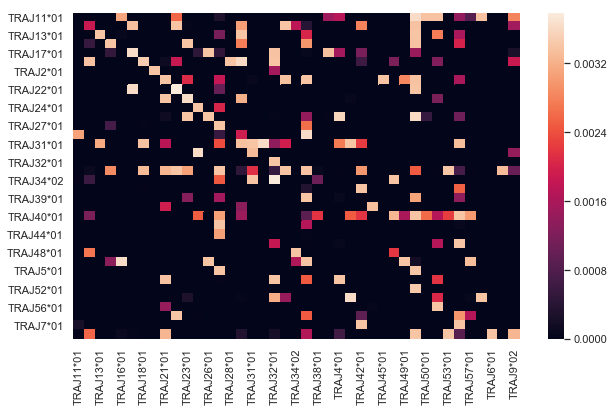

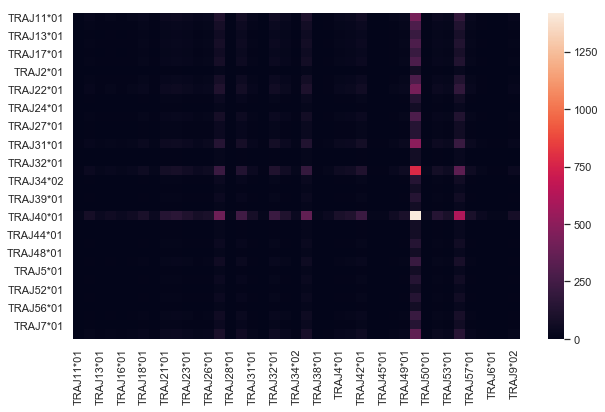

In [577]:
ja_gene_items = run_gene_analysis(full_df=clone_df, epitopes=('F2', 'M45'), gene='ja_gene')
plot_gene_analysis_results(ja_gene_items)

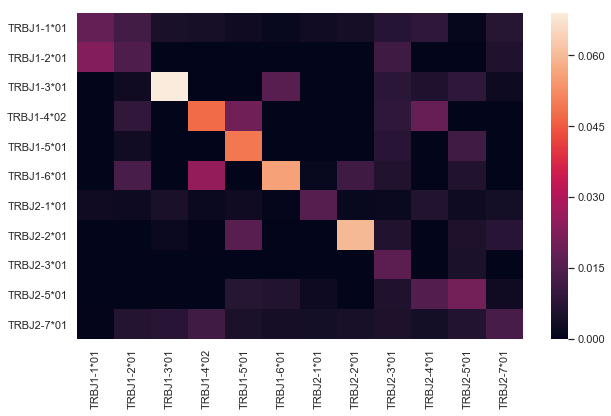

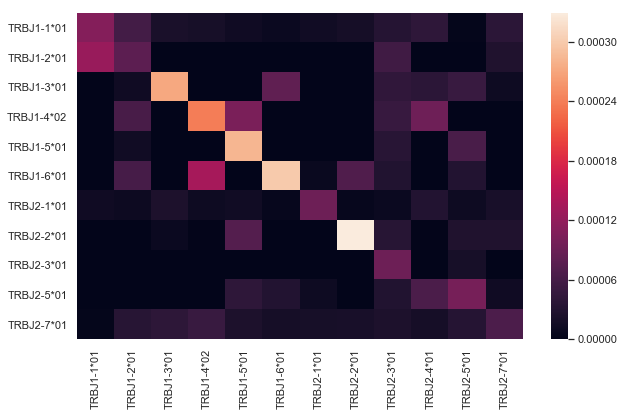

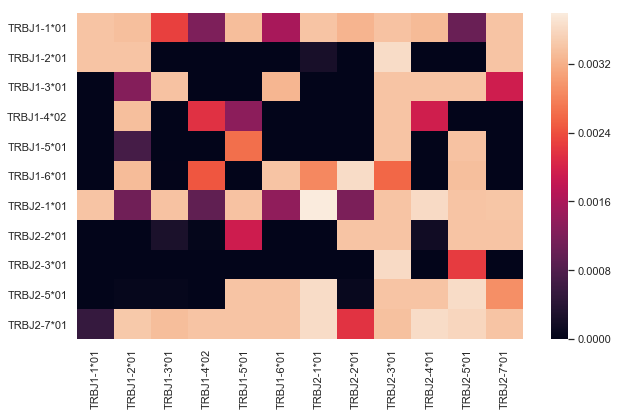

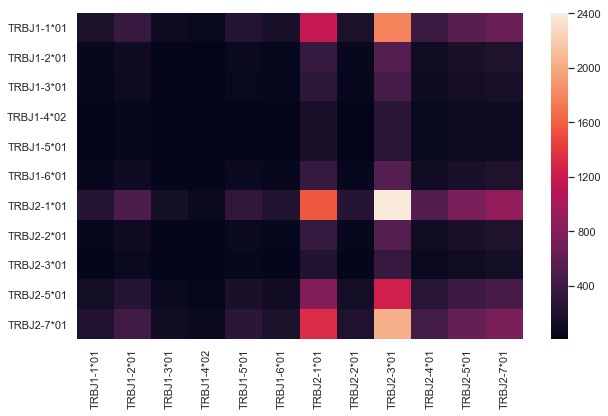

In [578]:
jb_gene_items = run_gene_analysis(full_df=clone_df, epitopes=('F2', 'M45'), gene='jb_gene')
plot_gene_analysis_results(jb_gene_items)